In [50]:
import numpy as np
import matplotlib

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from model import PModel, ADModel

#Global parameters for Pareto front
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 0.005    #Baseline transmission rate

#Parameters for evolutionary simulation
n_gens = 15
t = (0, 1000)

In [ ]:
def label_x_ticks(ax, vals, n_ticks = 4):
    x_lim = ax.get_xlim()
    x_ticks = np.linspace(x_lim[0], x_lim[1], n_ticks)
    x_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_xticks(x_ticks, x_tick_labels)

def label_y_ticks(ax, vals, n_ticks = 4):
    y_lim = ax.get_ylim()
    y_ticks = np.linspace(y_lim[0], y_lim[1], n_ticks)
    y_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_yticks(y_ticks, y_tick_labels)

In [ ]:
def diversity_panel(n_sims, n_loci=n_loci, epistasis=0, n_gens=n_gens, t=t, beta=beta):
	#Initialize model
	model = PModel(n_loci, np.zeros(n_loci), np.zeros(n_loci), beta=beta)
	
	threshold = 5

	#Counter variables for the number of monomorphic and polymorphic simulations
	n_mono = 0
	n_poly = 0

	n_div = np.zeros(n_sims)
	s_div = np.zeros(n_sims)

	for i in range(n_sims):
		print(i, end='\r')
		#Sample costs and benefits
		cost = np.random.exponential(0.1, n_loci)
		res = np.random.exponential(0.1, n_loci)

		#Update model parameters and add epistasis
		model.update_loci(res, cost)
		if epistasis == 1:
			model.add_epistasis(2, p1, sigma1)
		elif epistasis == 2:
			model.add_epistasis(2, p1, sigma1)
			model.add_epistasis(3, p2, sigma2)

		model.normalize()

		#Run dynamical simulation
		X_t, _ = model.run_sim(t, n_gens)

		#Check for polymorphism and update counters
		if np.sum(X_t[:, -1] > threshold) > 1:
			n_poly += 1
		else:
			n_mono += 1

		#Compute nucleotide diversity
		div = 0
		sum = np.sum(X_t[:, -1])

		for j in range(0, model.S_genotypes):
			for k in range(j + 1, model.S_genotypes):
				pi = np.sum(np.absolute(model.G[j] - model.G[k]))
				div += (X_t[j, -1]*X_t[k, -1]*pi) / sum**2

		n_div[i] = div*(sum / (sum + 1))

		#$Compute shannon diversity
		eq_prop = X_t[:,-1] / np.sum(X_t[:,-1])
		eq_prop = eq_prop[eq_prop > 0]
		s_div[i] = -np.sum(eq_prop*np.log(eq_prop))

	return n_div, s_div, n_poly/(n_poly+n_mono)

In [ ]:
from multiprocessing import Pool

def assign_func(epi_level):
    return diversity_panel(50, epistasis=epi_level, n_loci=9)

if __name__ == '__main__':
    with Pool(5) as p:
        results = p.map(assign_func, [0, 1, 2])

n_div_0, s_div_0, prop_0 = results[0]
n_div_1, s_div_1, prop_1 = results[1]
n_div_2, s_div_2, prop_2 = results[2]

In [ ]:
#Print the results of the simulation arrays
print('Polymorphism Frequency:')
print(prop_0, prop_1, prop_2)

print('Nucleotide Diversity:')
print('means:', np.mean(n_div_0), np.mean(n_div_1), np.mean(n_div_2))
print('standard deviations:', np.std(n_div_0), np.std(n_div_1), np.std(n_div_2))

print('Shannon Diversity:')
print('means:', np.mean(s_div_0), np.mean(s_div_1), np.mean(s_div_2))
print('standard deviations:', np.std(s_div_0), np.std(s_div_1), np.std(s_div_2))

In [13]:
#Compute equilibrium susceptible prevalence
def S_star(beta, mu=0.2):
    return mu / beta

#Calculate equilibrium infected prevalence 
def I_star(beta, b, mu=0.2, k=0.001):
    return (beta*(b - mu) - k*mu) / (beta*(k + beta))

#Calculate pairwise invasion fitness
def invasion_fitness(b_res, beta_res, b_mut, beta_mut, mu=0.2, k=0.001):
    return b_mut - mu - k*(S_star(beta_res) + I_star(beta_res, b_res)) - beta_mut*I_star(beta_res, b_res)

In [83]:
#Initialize discrete random loci model
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

PF_model = PModel(n_loci, res, cost, beta=beta)
PF_model.normalize()

#run dynamical simulation
X_t, I_t = PF_model.run_sim(t, n_gens)

#Resample results into time and genotype bins to create a raster
n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, PF_model.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < PF_model.B,PF_model.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals,time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

#Compute pareto front and interpolate from model
res_vals = np.linspace(0, np.max(PF_model.B), 100)
res_pts, fec_pts = PF_model.pareto()
fec_interp = np.interp(res_vals, res_pts, fec_pts)

coefs = np.polyfit(res_vals, fec_interp, 5)
fec_vals = np.poly1d(coefs)(res_vals)

In [88]:
#Initialize an adaptive dynamics model based on the trade-off function
AD_sim = ADModel(res=res_vals, b=fec_vals)
results = AD_sim.run_sim()

#Retrieve pareto genotypes and remove genotype with zero transmission
res_pareto, fec_pareto = PF_model.pareto()
fec_pareto = fec_pareto[res_pareto > 0]
res_pareto = res_pareto[res_pareto > 0]

dim_pareto = len(res_pareto)

PIP_pareto = np.zeros((dim_pareto, dim_pareto))

#Go through all genotype pairs and compute invasion fitness
for i in range(dim_pareto):
    for j in range(dim_pareto):
        diff = invasion_fitness(fec_pareto[i], res_pareto[i], fec_pareto[j], res_pareto[j])
        if diff > 0:
            PIP_pareto[i, j] = 1
        elif diff <= 0 or i == j:
            PIP_pareto[i, j] = 2

dim_approx = 1000

PIP_approx = np.zeros((dim_approx, dim_approx))

#Get polynomial approximation of the pareto front
res_approx = np.linspace(np.min(res_pareto), np.max(res_pareto), dim_approx)
fec_interp = np.interp(res_approx, res_pareto, fec_pareto)

coefs = np.polyfit(res_approx, fec_interp, 5)
fec_approx = np.poly1d(coefs)(res_approx)

#Go through all genotype pairs and compute invasion fitness
for i in range(dim_approx):
    for j in range(dim_approx):
        diff = invasion_fitness(fec_approx[i], res_approx[i], fec_approx[j], res_approx[j])
        if diff > 0:
            PIP_approx[i, j] = 1
        elif diff <= 0 or i == j:
            PIP_approx[i, j] = 2
        

Text(0.5, 1.0, 'Pareto Genotypes')

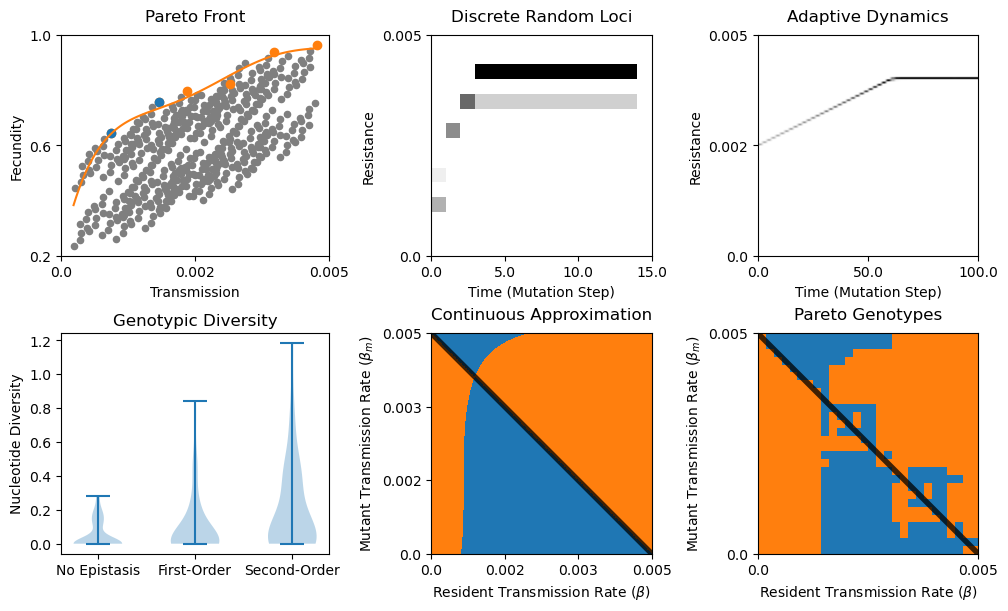

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), layout='constrained')

abundances = np.max(X_t, axis=1)

ax[0,0].scatter(PF_model.B[abundances <= 1], PF_model.F[abundances <= 1], c='tab:gray', s=20)
ax[0,0].scatter(PF_model.B[abundances > 1], PF_model.F[abundances > 1], c='tab:orange')
ax[0,0].scatter(PF_model.B[X_t[:,-1] > 1], PF_model.F[X_t[:,-1] > 1], c='tab:blue')

ax[0,0].plot(res_vals, fec_vals, color='tab:orange')
ax[0,0].set_title('Pareto Front', pad=10)
ax[0,0].set_ylabel('Fecundity')
ax[0,0].set_xlabel('Transmission')

label_x_ticks(ax[0,0], PF_model.B, 3)
label_y_ticks(ax[0,0], PF_model.F, 3)

genotypes = ax[0,1].imshow(np.log(1+evol_plot), cmap='Greys')
ax[0,1].set_title('Discrete Random Loci', pad=10)
ax[0,1].set_ylabel('Resistance')
ax[0,1].set_xlabel('Time (Mutation Step)')

label_x_ticks(ax[0,1], np.linspace(0, n_time_bins, dtype=np.uint), 4)
label_y_ticks(ax[0,1], PF_model.B, 2)

ax[0,2].imshow(results[0], extent=[0,1,0,1], cmap='Greys')
ax[0,2].set_title('Adaptive Dynamics', pad=10)
ax[0,2].set_ylabel('Resistance')
ax[0,2].set_xlabel('Time (Mutation Step)')

label_x_ticks(ax[0,2], np.linspace(0, 100, 5, dtype=np.uint), 3)
label_y_ticks(ax[0,2], res_vals, 3)

ax[1,0].set_title('Genotypic Diversity')
ax[1,0].violinplot((n_div_0, n_div_1, n_div_2))
ax[1,0].set_xticks([1,2,3], ['No Epistasis', 'First-Order', 'Second-Order'])
ax[1,0].set_ylabel('Nucleotide Diversity')

cmap = matplotlib.colors.ListedColormap(['tab:orange', 'tab:blue'])

ax[1,1].imshow(PIP_approx.T, cmap=cmap)
ax[1,2].imshow(PIP_pareto.T, cmap=cmap)

lims_1 = [
    np.min([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
    np.max([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
]

lims_2 = [
    np.min([ax[1,2].get_xlim(), ax[1,2].get_ylim()]),
    np.max([ax[1,2].get_xlim(), ax[1,2].get_ylim()]),
]

ax[1,1].plot(lims_1, lims_1, 'k-', alpha=0.75, zorder=0, linewidth=4)
ax[1,2].plot(lims_2, lims_2, 'k-', alpha=0.75, zorder=0, linewidth=4)

label_x_ticks(ax[1,1], res_approx)
label_y_ticks(ax[1,1], res_approx)
label_x_ticks(ax[1,2], res_pareto, n_ticks=2)
label_y_ticks(ax[1,2], res_pareto, n_ticks=2)

ax[1,1].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[1,1].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')

ax[1,2].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[1,2].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')

ax[1,1].set_title('Continuous Approximation', pad=10)
ax[1,2].set_title('Pareto Genotypes', pad=10)